INFO:data:Loading data from ../data/synthetic_crop_prices.csv
INFO:data:Loaded 54,810 records
INFO:data:Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
INFO:data:Markets: 10
INFO:data:Crops: ['maize', 'rice', 'wheat']


Rice data: 18,270 records


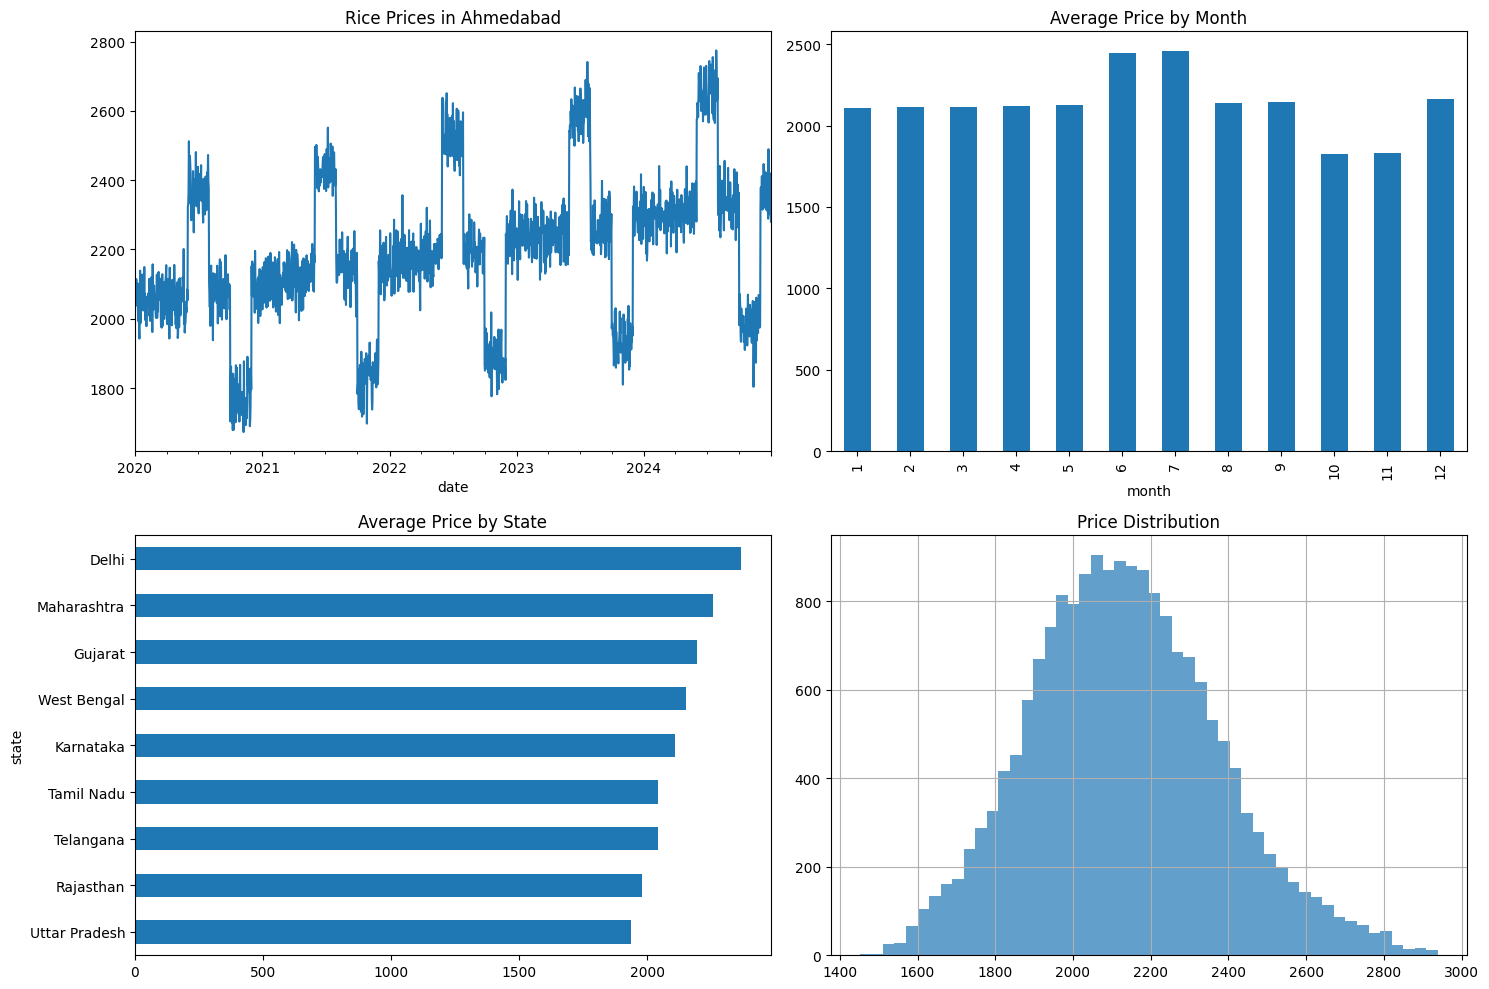

INFO:data:Starting data preprocessing
INFO:data:Aggregated data to weekly frequency
INFO:data:Shape after aggregation: (9093, 15)
INFO:data:Data shape after preprocessing: (9093, 15)
INFO:features:Starting feature engineering
INFO:features:Final feature matrix shape: (9093, 39)
INFO:features:Features: ['market', 'crop', 'variety', 'state', 'district', 'arrival_qty', 'acreage_estimate', 'rainfall_mm', 'temp_c', 'govt_policy_flag', 'holiday_flag', 'year', 'month', 'quarter', 'week_of_year', 'day_of_week', 'is_harvest_month', 'month_sin', 'month_cos', 'lag_1', 'arrival_lag_1', 'lag_2', 'arrival_lag_2', 'lag_4', 'arrival_lag_4', 'lag_12', 'arrival_lag_12', 'rolling_mean_4', 'rolling_std_4', 'arrival_rolling_mean_4', 'rolling_mean_12', 'rolling_std_12', 'arrival_rolling_mean_12', 'market_encoded', 'state_encoded', 'variety_Basmati', 'variety_PR 126', 'variety_Sona Masoori', 'variety_Swarna']


TypeError: Cannot convert [['Ahmedabad' 'Ahmedabad' 'Ahmedabad' ... 'Pune' 'Pune' 'Pune']
 ['rice' 'rice' 'rice' ... 'rice' 'rice' 'rice']
 ['PR 126' 'Sona Masoori' 'Basmati' ... 'Sona Masoori' 'Swarna'
  'Sona Masoori']
 ['Gujarat' 'Gujarat' 'Gujarat' ... 'Maharashtra' 'Maharashtra'
  'Maharashtra']
 ['Ahmedabad' 'Ahmedabad' 'Ahmedabad' ... 'Pune' 'Pune' 'Pune']] to numeric

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import project modules
import sys
sys.path.append('../src')
from data import DataLoader, DataPreprocessor
from features import FeatureEngineer
from models import LightGBMPredictor, LSTMPredictor
from eval import ModelEvaluator

# Load configuration
import yaml
with open('../config.yml', 'r') as f:
    config = yaml.safe_load(f)

# 1. Data Loading and EDA
data_loader = DataLoader(config)
df = data_loader.load_from_csv('../data/synthetic_crop_prices.csv')

# Filter for rice
rice_df = df[df['crop'] == 'rice'].copy()
print(f"Rice data: {len(rice_df):,} records")

# EDA Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price over time
sample_market = rice_df['market'].iloc[0]
market_data = rice_df[rice_df['market'] == sample_market]
market_data.groupby('date')['modal_price'].mean().plot(ax=axes[0,0], title=f'Rice Prices in {sample_market}')

# Seasonality by month
rice_df['month'] = rice_df['date'].dt.month
rice_df.groupby('month')['modal_price'].mean().plot(kind='bar', ax=axes[0,1], title='Average Price by Month')

# Per-state comparison
rice_df.groupby('state')['modal_price'].mean().sort_values().plot(kind='barh', ax=axes[1,0], title='Average Price by State')

# Price distribution
rice_df['modal_price'].hist(bins=50, ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Price Distribution')

plt.tight_layout()
plt.show()

# 2. Data Preprocessing
preprocessor = DataPreprocessor(config)
df_processed = preprocessor.transform(rice_df)

# 3. Feature Engineering
feature_engineer = FeatureEngineer(config)
feature_engineer.fit(df_processed)
X, y = feature_engineer.transform(df_processed)

# Handle missing values
X = X.fillna(X.median())
valid_indices = ~y.isnull()
X, y = X[valid_indices], y[valid_indices]

print(f"Final feature matrix: {X.shape}")

# 4. Model Training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

# Train LightGBM
lgb_predictor = LightGBMPredictor(config)
lgb_predictor.train(X_train, y_train.values, X_test, y_test.values)

# 5. Model Evaluation
evaluator = ModelEvaluator(config)

# Predictions
y_pred_lgb = lgb_predictor.predict(X_test)

# Calculate metrics
metrics = evaluator.calculate_metrics(y_test.values, y_pred_lgb)
print("LightGBM Performance:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Plot predictions
fig = evaluator.plot_predictions(y_test.values, y_pred_lgb, title="LightGBM: Actual vs Predicted")
plt.show()

# Feature importance (if available)
if hasattr(lgb_predictor.model, 'feature_importances_'):
    feature_importance = dict(zip(X.columns, lgb_predictor.model.feature_importances_))
    fig = plot_feature_importance(feature_importance)
    plt.show()

# 6. SHAP Analysis
fig = evaluator.generate_shap_analysis(lgb_predictor.model, X_test, X.columns.tolist())
plt.show()